# Project I: Multi-Armed Bandits

The multi-armed bandit problem considers a resource allocation problem in partially unknown environments. In more detail, the problem refers to the task of allocating a fixed and limited set of resources among alternative choices in a way that maximizes the expected gain. Importantly, each choice's properties are only partially known at the time of allocation and may become better understood with time and/or by allocating resources to a choice. The multi-armed bandit problem is a classic reinforcement learning problem that demonstrates the exploration-exploitation tradeoff dilemma and related concepts in a clear non-associative form. As such, it helps set the foundations of reinforcement learning theory. The multi-armed bandit problem has also applications in various domains such as clinical trials and networking. In this notebook we will experiment with a number of multiarmed bandit algorithms by altering the abstract bandit algorithm.

![robot](img/robot.png)

## Section 1: General Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Section 2: The General Bandit Algorithm

![algorithm](img/abstract_algorithm.png)

Here we declare a general bandit algorithm that accepts various initialization, action selection and update strategies.

In [4]:
def bandit(inputs):
    """
        An abstract k-arm bandit algorithm.

        Args:
            inputs: A dictionary containing the number of actions "k", the number of iterations "horizon",
                    the true unknown rewards "q_star", the initialization strategy function "initialization",
                    the action selection strategy function "action_selection", the update rule function "update rule"
                    and any other parameters required.

        Returns:
            q_estimates: list - the estimates of the q values.
            total_reward: float - the cummulative reward
            mean_rewards: list - the consecutive mean rewards
            regret: list - the true maximum regret

    """
    
    #Initializing rewards and regret (used mainly for evaluation purposes)
    total_reward = 0
    mean_rewards = np.zeros(inputs["horizon"])
    regret = np.zeros(inputs["horizon"])
    
    #Initialize an action selection counter (used mainly for the true average update rule)
    action_select_counter = np.zeros(k)
    
    ### INITIALIZE THE ESTIMATES
    q_estimates = inputs["initialization"](inputs["k"], inputs["q_star"])
    
    for t in range(1,inputs["horizon"]+1): # loop over the horizon
        
        ### ACTION SELECTION
        action = inputs["action_selection"](q_estimates, inputs, t, action_select_counter)    
        # Update action counter
        action_select_counter[action] += 1
    
        ## BANDIT CALL
        reward = run_bandit(action, q_star) 
        
        #Calculate reward, mean reward and regret for evaluatuion purposes
        total_reward += reward      
        mean_rewards[t-1] = total_reward/t
        regret[t-1] = np.max(q_star) - reward # We use the true maximum to calculate the regret :)
        
        ## UPDATE ACTION-VALUE ESTIMATES
        q_estimates = inputs["update_rule"](q_estimates, action, reward, inputs, action_select_counter, mean_rewards[t-1])
        
    return q_estimates, total_reward, mean_rewards, regret

In [5]:
def run_bandit(action, q_star):
    """ 
        Returns the reward of an action assuming that it follows a normal distribution with variance 1.
        The mean values are extracted from q_star 
    """
    return rng2.normal(q_star[action], 1)

### 2.1. Initialization strategies
Using the q* values, we create initialization methods that implement zero, pessimistic, average, optimistic and random estimate initializations for the bandit algorithm:

#### Estimate initialization with zeroes:

In [6]:
def ZeroInitialization(k, q_star):
    """Zero initialization"""
    return np.zeros(k)

#### Pessimistic estimate initialization:

In [7]:
def MinInitialization(k, q_star):
    """Min initialization"""
    return np.ones(k) * np.min(q_star)

#### Mean estimate initialization:

In [8]:
def MeanInitialization(k, q_star):
    """Mean initialization"""
    return np.ones(k) * np.mean(q_star)

#### Optimistic estimate initialization:

In [9]:
def MaxInitialization(k, q_star):
    """Max initialization"""
    return np.ones(k) * np.max(q_star)

#### Estimate initialization with random numbers:

In [10]:
def RandomInitialization(k, q_star):
    """Random initialization"""
    return rng3.normal(0, 1, k)  #let's assume we know the distributions and take nice random initial values :)

### 2.2. Action selection strategies

#### Random action selection: 
This strategy selects an action completely at random without taking into account the learned estimates.

In [11]:
def random_action_selection(estimates, bandit_inputs, t, action_select_counter):
    """Choose an action randomly (uniform)"""
    return rng2.randint(inputs["k"])

#### Greedy action selection:
This action selection strategy always selects the best possible action.

In [12]:
def greedy_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the greedy action selection"""
    return np.argmax(estimates)

#### ε-Greedy action selection:
The implementation of the e-Greedy algorithm for the multi-armed bandit problem.

In [13]:
def e_greedy_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the e-greedy action selection"""
    # Generate a random number
    p = rng2.rand()
    
    # E-Greedy action selection
    if p < inputs["epsilon"]:
        # Randomly select an action
        return rng2.choice(inputs["k"])
    else:
        # Take greedy action
        return np.argmax(estimates)

#### ε-Greedy with epsion decay action selection:
The implementation of the e-Greedy algorithm with epsilon decay for the multi-armed bandit problem.

In [14]:
def e_decay_greedy_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the e-greedy with epsilon decay action selection"""
    # Generate a random number
    p = rng2.rand()

    # E-Greedy action selection
    if p < inputs["epsilon"]*np.exp(-inputs["kappa"]*t):
        # Randomly select an action
        action = rng2.choice(inputs["k"])
    else:
        # Take greedy action
        action = np.argmax(estimates)
            
    return action

#### Upper Confidence Bound action selection:
The implementation of the UCB algorithm for the multi armed bandit problem.

In [15]:
def ucb_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the UCB action selection"""
    t = np.sum(action_select_counter) + 1
    # Select action according to UCB Criteria
    return np.argmax(estimates + inputs["c"] * np.sqrt(np.log(t) / (action_select_counter+1)))

#### SoftMax action selection:
The implementation of the softmax bandit algorithm for the multi-armed bandit problem. 

In [16]:
def softmax_action_selection(estimates, inputs, t, action_select_counter):
    """ Choose an action using the Softmax action selection"""
    # Softmax action selection
    action = rng3.choice(inputs["k"], 1, p=np.exp(estimates/inputs["tau"]) / np.sum(np.exp(estimates/inputs["tau"])))
    return action[0]

### 2.3. Update strategies 

#### True average update rule:

In [17]:
def update_rule(estimates, action, reward, inputs, action_select_counter, mean_reward):
    """ Return the estimates using the true average update rule"""
    # Update the estimates
    estimates[action] = estimates[action] + (reward - estimates[action]) / action_select_counter[action]
    return estimates

#### Constant learning rate update rule:

In [18]:
def update_rule_constant_lr(estimates, action, reward, inputs, action_select_counter, mean_reward):
    # Update the estimates
    """ Return the estimates using the constant learning rate update rule"""
    estimates[action] = estimates[action] + (reward - estimates[action]) / (action_select_counter[action]*inputs["a"])
    return estimates

What about decaying learning rate?

## Section 3: The Case Study Experiment

Here we declare the number of trials and arms of the multi-armed bandit problem. We also select a gaussian probability distribution to generate the true values of each arm and to simulate the randomness of the experiment.

In [19]:
# Number of actions
k = 10
# Number of iterations
horizon = 5000
#Number of trials
trials=100

# Initialization of the true action values (q*) according to a gaussian distribution

q_star = [-0.70318731, -0.49028236, -0.32181433, -1.75507872,  0.20666447, -2.01126457, -0.55725071,  0.33721701,  1.54883597, -1.37073656]
#rng1 = np.random.RandomState(1337) #https://en.wikipedia.org/wiki/Leet
#q_star = rng1.normal(0, 1, k)
#print(q_star)

### 3.1. Experimental procedure 

Define the experimental procedure followed for all experiments

In [20]:
def procedure(inputs, N):
    """ 
        Does "trials" amount of runs of the algorithm specified by the "inputs" dictionary. 
    
        Args:
            inputs: A dictionary containing the number of actions "k", the number of iterations "horizon",
                    the true unknown rewards "q_star", the initialization strategy function "initialization",
                    the action selection strategy function "action_selection", the update rule function "update rule"
                    and any other parameters required.
            trials: The amount of trial runs to execute so we can get the average performance of the algorithm

        Returns:
            average_q_estimates: list - the average estimates of the q values.
            average_total_reward: float - the average cummulative reward
            average_mean_rewards: list - the average consecutive mean rewards
            average_regret: list - the average true maximum regret
    """
    #Initialize the evaluation parameters
    estimates = np.zeros(k)
    total_reward = 0
    mean_rewards = np.zeros(N)
    regret = np.zeros(N)

    #Run the n trials of the experiment
    for i in range(trials):
        i_estimates, i_total_reward, i_mean_rewards, i_regret = bandit(inputs)
        estimates += i_estimates
        total_reward += i_total_reward
        mean_rewards += i_mean_rewards
        regret += i_regret
        
    return estimates/trials, total_reward/trials, mean_rewards/trials, regret/trials #return the average results for all trials

### 3.2. Plotting/printing:
After each experiment we print two plots to evaluate the performance of the algorithm. We print the loss that we incur due to time/rounds spent due to the learning, or else the regret, and the expected reward of the algorithm across the rounds of each experiment.

Definition of the print and plot of the results (we use this throughout the rest of the notebook):

In [21]:
def plot_bandits(N, estimates, total_reward, mean_rewards, regret, q_star):
    """ Plots using matplotlib the regret curve and the average reward curve"""
    print("True q values:{}".format(q_star))
    print("Learned Estimates: {}".format(estimates))
    print("")
    print("Euclidean distance from q_star vector: {}".format(np.linalg.norm(q_star-estimates)))
    print("Total Reward: {}".format(total_reward))
    print("Mean Reward: {}".format(mean_rewards[-1]))

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), np.cumsum(regret), 'b-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Total Regret',
           title='Regret Curve')

    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,N-1,N), mean_rewards, 'b-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Average Reward',
           title='Average Reward Curve')

    plt.show()

Definition of the comp_plot, that plots the comparative plot of the various initializations:

In [22]:
def comp_plot(regret, pes_regret, avg_regret, opt_regret, rnd_regret, \
              mean_rewards, pes_mean_rewards, avg_mean_rewards, opt_mean_rewards, rnd_mean_rewards):
    """ Plots using matplotlib a comparison of the the regret curves and the average reward curves"""
    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret), 'b-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(opt_regret), 'g-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(avg_regret), 'r-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(pes_regret), 'c-')
    ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(rnd_regret), 'y-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Total Regret',
           title='Regret Curve')
    plt.legend(['Zero','Optimistic','Mean','Pesimistic','Random'])
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards, 'b-')
    ax.plot(np.linspace(0,horizon-1,horizon), opt_mean_rewards, 'g-')
    ax.plot(np.linspace(0,horizon-1,horizon), avg_mean_rewards, 'r-')
    ax.plot(np.linspace(0,horizon-1,horizon), pes_mean_rewards, 'c-')
    ax.plot(np.linspace(0,horizon-1,horizon), rnd_mean_rewards, 'y-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Speed")
    ax.grid()
    ax.set(xlabel='Time Steps', ylabel='Average Reward',
           title='Average Reward Curve')
    plt.legend(['Zero','Optimistic','Mean','Pesimistic','Random'])
    plt.show()

## Section 4. The bandit algorithm with random action selection and true average update (Experiment I)

### 4.1. Initializing with zero values:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.70063846 -0.49270771 -0.3200305  -1.76013991  0.20623764 -2.00577644
 -0.55665471  0.33438762  1.55087664 -1.36834396]

Euclidean distance from q_star vector: 0.009472480378776167
Total Reward: -2566.771691278456
Mean Reward: -0.513354338255691


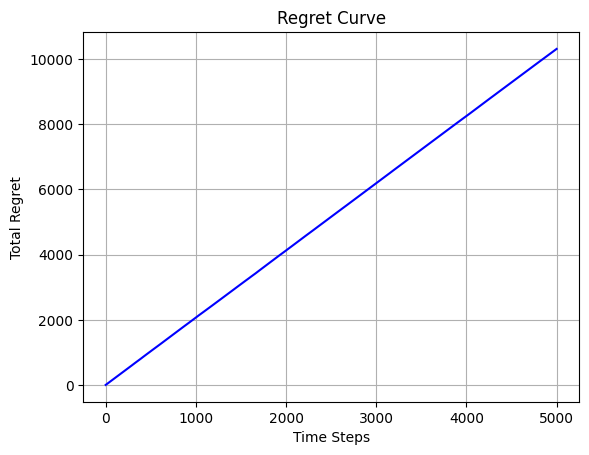

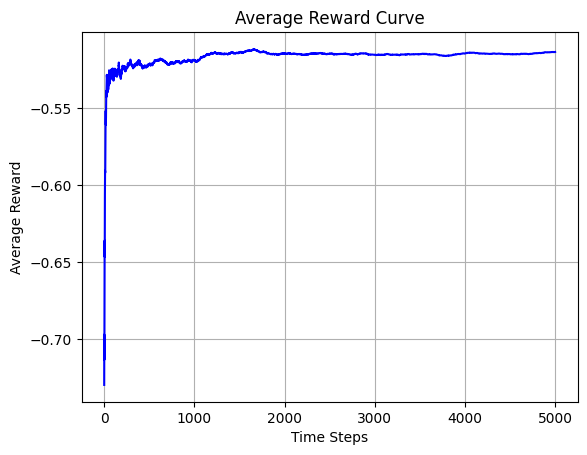

In [21]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : random_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
estimates_rand, total_reward_rand, mean_rewards_rand, regret_rand = procedure(inputs,horizon)
plot_bandits(horizon, estimates_rand, total_reward_rand, mean_rewards_rand, regret_rand, q_star)

### 4.2. Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.70063846 -0.49270771 -0.3200305  -1.76013991  0.20623764 -2.00577644
 -0.55665471  0.33438762  1.55087664 -1.36834396]

Euclidean distance from q_star vector: 0.009472480378776167
Total Reward: -2566.771691278456
Mean Reward: -0.513354338255691


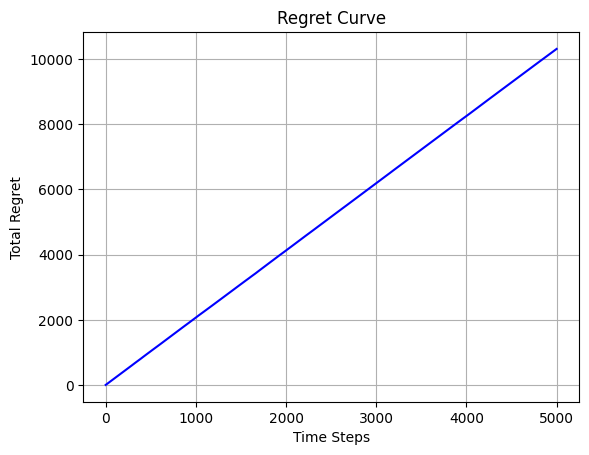

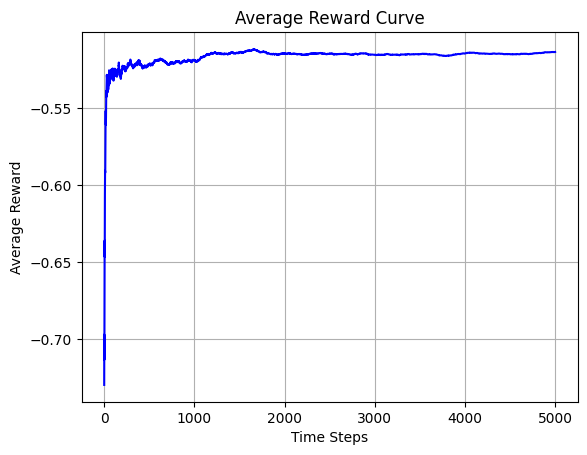

In [22]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : random_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
min_estimates_rand, min_total_reward_rand, min_mean_rewards_rand, min_regret_rand = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_rand, min_total_reward_rand, min_mean_rewards_rand, min_regret_rand, q_star)

### 4.3. Initializing with Mean:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.70063846 -0.49270771 -0.3200305  -1.76013991  0.20623764 -2.00577644
 -0.55665471  0.33438762  1.55087664 -1.36834396]

Euclidean distance from q_star vector: 0.009472480378776167
Total Reward: -2566.771691278456
Mean Reward: -0.513354338255691


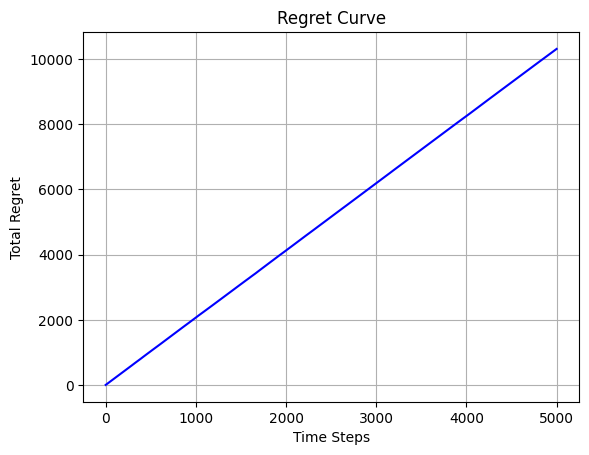

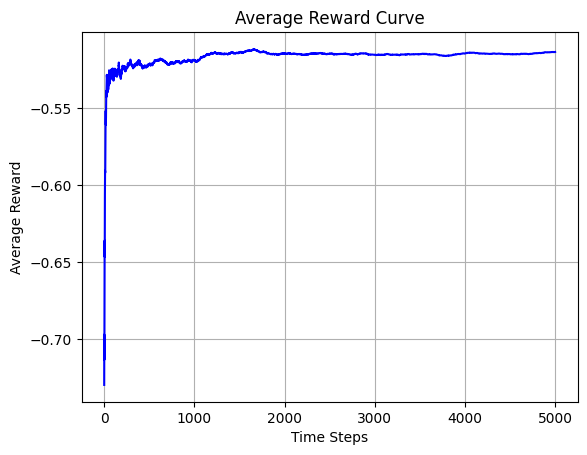

In [23]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : random_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
avg_estimates_rand, avg_total_reward_rand, avg_mean_rewards_rand, avg_regret_rand = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_rand, avg_total_reward_rand, avg_mean_rewards_rand, avg_regret_rand, q_star)

### 4.4. Initializing with Optimistic:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.70063846 -0.49270771 -0.3200305  -1.76013991  0.20623764 -2.00577644
 -0.55665471  0.33438762  1.55087664 -1.36834396]

Euclidean distance from q_star vector: 0.009472480378776167
Total Reward: -2566.771691278456
Mean Reward: -0.513354338255691


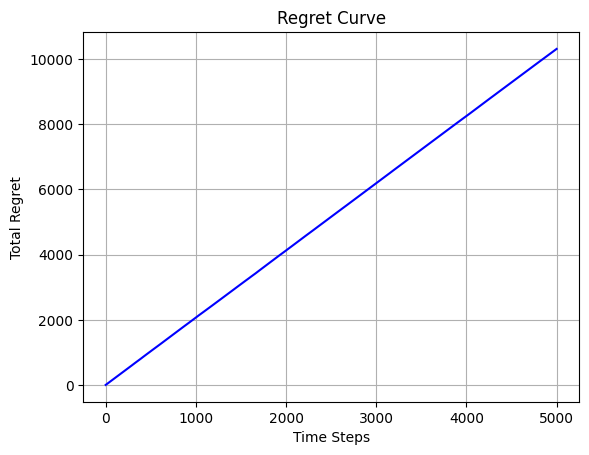

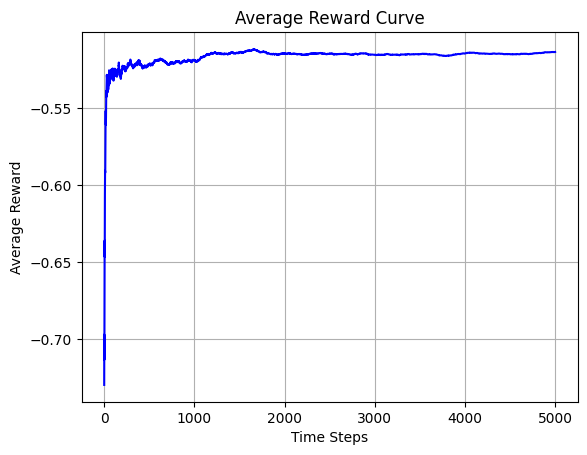

In [24]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : random_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
max_estimates_rand, max_total_reward_rand, max_mean_rewards_rand, max_regret_rand = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_rand, max_total_reward_rand, max_mean_rewards_rand, max_regret_rand, q_star)

### 4.5. Initializing with Random
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.70063846 -0.49270771 -0.3200305  -1.76013991  0.20623764 -2.00577644
 -0.55665471  0.33438762  1.55087664 -1.36834396]

Euclidean distance from q_star vector: 0.009472480378776167
Total Reward: -2566.771691278456
Mean Reward: -0.513354338255691


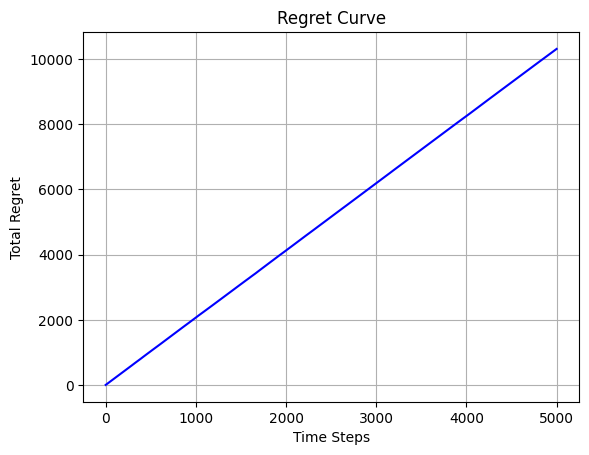

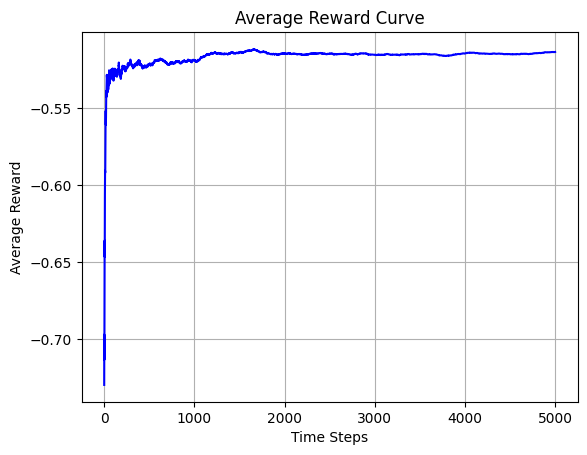

In [25]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : random_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
rnd_estimates_rand, rnd_total_reward_rand, rnd_mean_rewards_rand, rnd_regret_rand = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_rand, rnd_total_reward_rand, rnd_mean_rewards_rand, rnd_regret_rand, q_star)

### 4.6. Compare all:

Let's see a comparison between the different initialization strategies for the random action selection strategy:

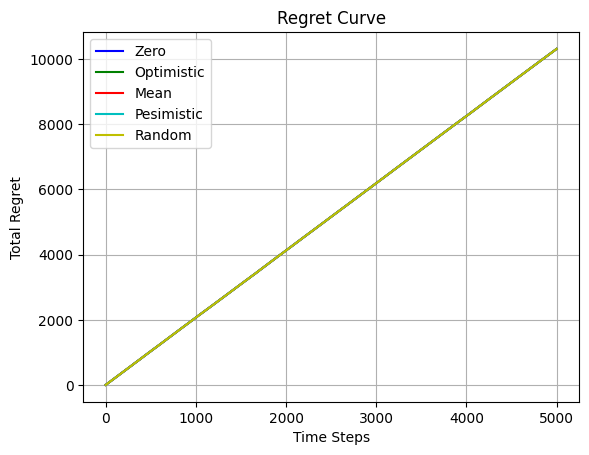

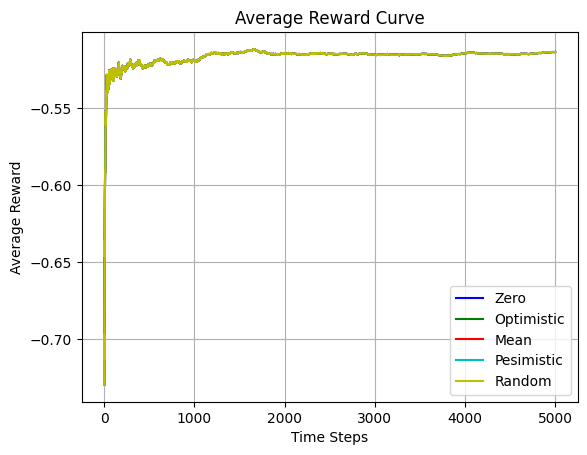

In [26]:
comp_plot(regret_rand, min_regret_rand, avg_regret_rand, max_regret_rand, rnd_regret_rand, \
          mean_rewards_rand, min_mean_rewards_rand, avg_mean_rewards_rand, max_mean_rewards_rand, rnd_mean_rewards_rand)

## Section 5: The bandit algorithm with greedy action selection and true average update (Experiment II)

### 5.1. Initializing with zero values:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.81910377 -0.69032498 -0.64782405 -1.73993846 -0.32000785 -1.4556711
 -0.70004546 -0.04496265  0.67585103 -0.02313117]

Euclidean distance from q_star vector: 1.868322165871008
Total Reward: 4150.630000434204
Mean Reward: 0.830126000086841


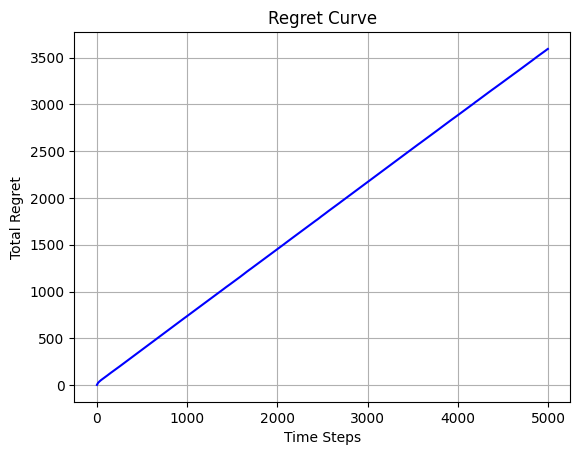

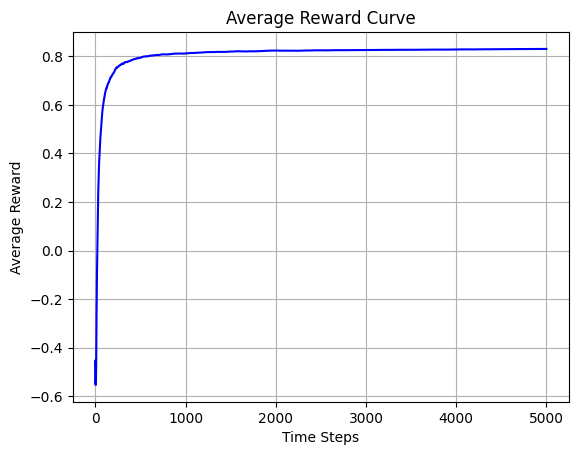

In [27]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
estimates_greedy, total_reward_greedy, mean_rewards_greedy, regret_greedy = procedure(inputs,horizon)
plot_bandits(horizon, estimates_greedy, total_reward_greedy, mean_rewards_greedy, regret_greedy, q_star)

### 5.2. Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.73449468 -1.980676   -2.01126457 -2.01126457 -2.01126457 -2.01126457
 -2.01126457 -2.01126457 -2.01126457 -2.01126457]

Euclidean distance from q_star vector: 5.547562518504375
Total Reward: -3492.727953875595
Mean Reward: -0.6985455907751194


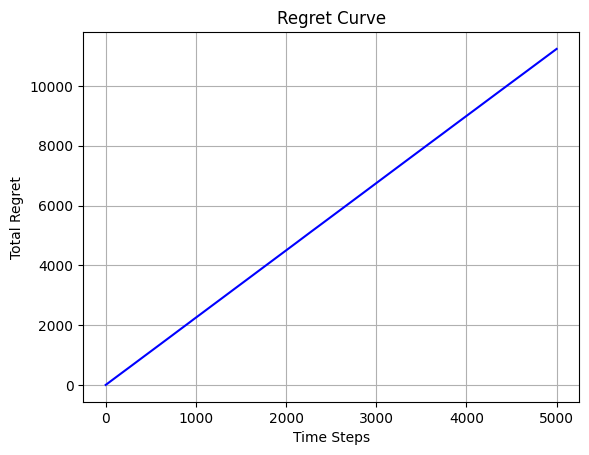

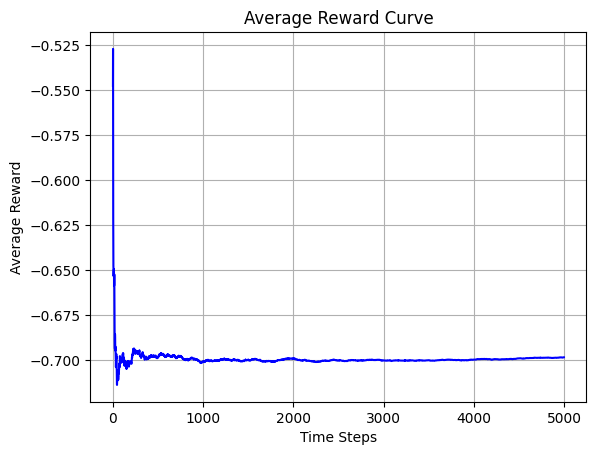

In [28]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
min_estimates_greedy, min_total_reward_greedy, min_mean_rewards_greedy, min_regret_greedy = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_greedy, min_total_reward_greedy, min_mean_rewards_greedy, min_regret_greedy, q_star)

### 5.3. Initializing with Mean:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.97112424 -0.87400525 -0.78772053 -1.38027823 -0.30824213 -0.9068198
 -0.61756809 -0.3655788  -0.36731353 -0.51168971]

Euclidean distance from q_star vector: 2.6398210210340523
Total Reward: 907.0820030714052
Mean Reward: 0.18141640061428102


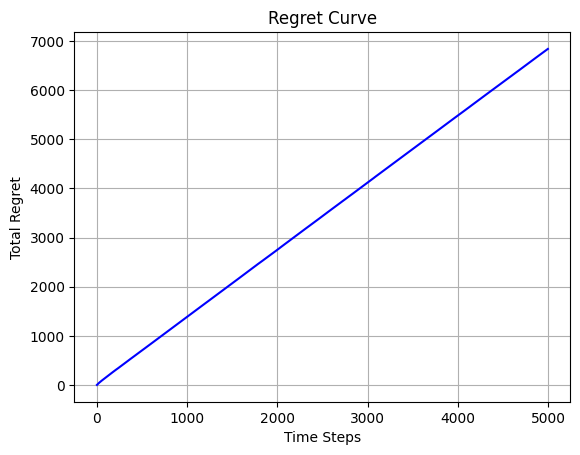

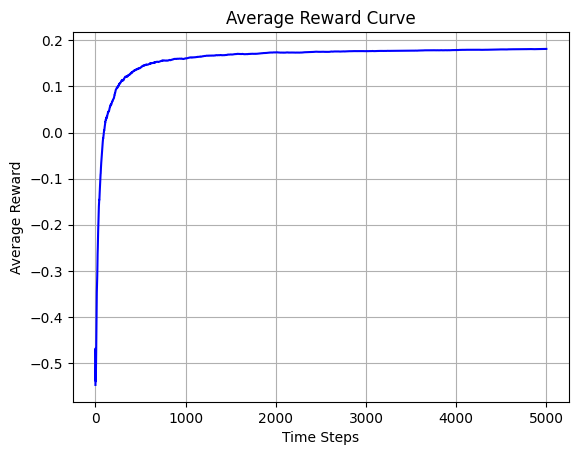

In [29]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
avg_estimates_greedy, avg_total_reward_greedy, avg_mean_rewards_greedy, avg_regret_greedy = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_greedy, avg_total_reward_greedy, avg_mean_rewards_greedy, avg_regret_greedy, q_star)

### 5.4. Initializing with Optimistic:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.61878927 -0.42028672 -0.52856253 -1.67878419 -0.0465859  -1.98179591
 -0.59029234  0.1179506   1.48363286 -1.3284534 ]

Euclidean distance from q_star vector: 0.4252070845158833
Total Reward: 7477.511905142106
Mean Reward: 1.4955023810284211


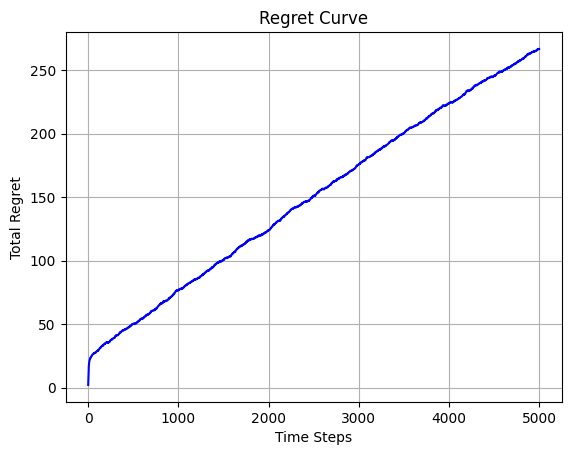

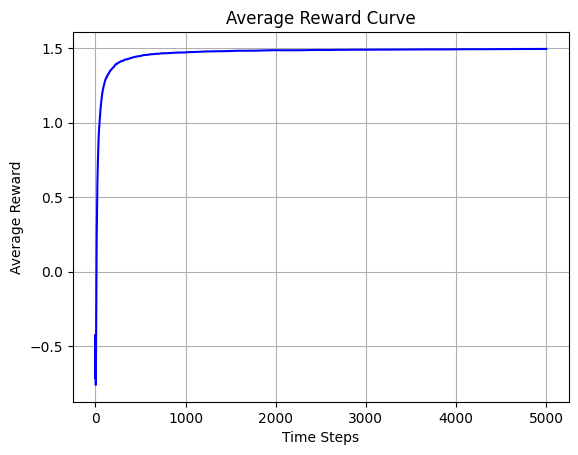

In [30]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
max_estimates_greedy, max_total_reward_greedy, max_mean_rewards_greedy, max_regret_greedy = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_greedy, max_total_reward_greedy, max_mean_rewards_greedy, max_regret_greedy, q_star)

### 5.5. Initializing with Random
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.77041847 -0.76912592 -0.70294793 -1.28304244 -0.3857596  -1.16529952
 -0.61920856 -0.39995101  0.51097971 -0.88423414]

Euclidean distance from q_star vector: 1.837950942732177
Total Reward: 4936.8324828709065
Mean Reward: 0.9873664965741809


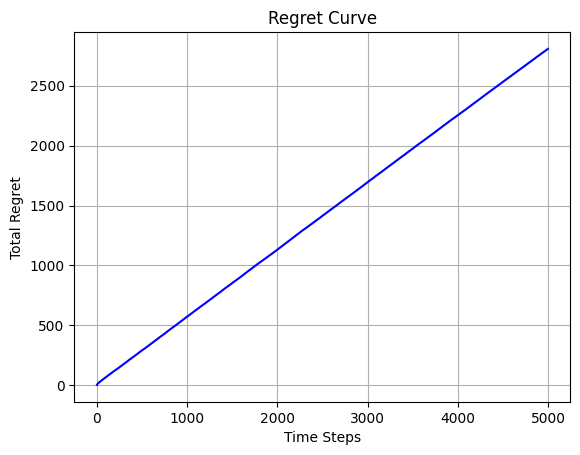

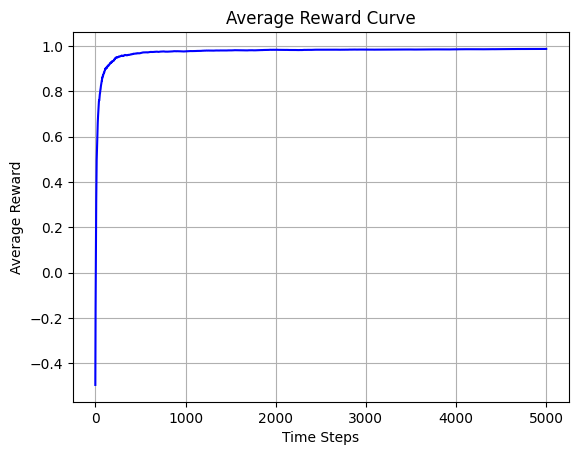

In [31]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule # The update rule
         }

#Run the experiment and plot:
rnd_estimates_greedy, rnd_total_reward_greedy, rnd_mean_rewards_greedy, rnd_regret_greedy = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_greedy, rnd_total_reward_greedy, rnd_mean_rewards_greedy, rnd_regret_greedy, q_star)

### 5.6 Compare all:

Let's see a comparison between the different initialization strategies for the random action selection strategy:

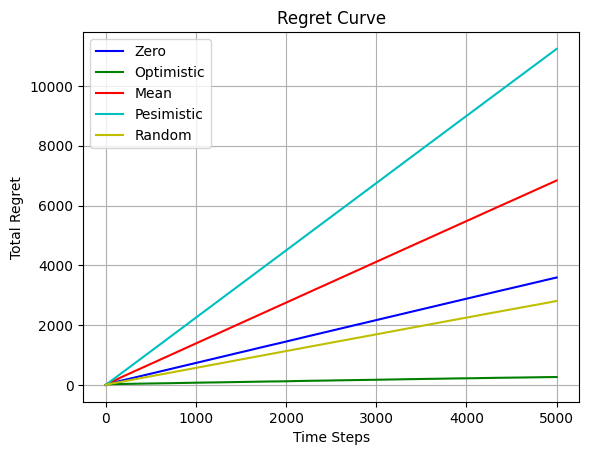

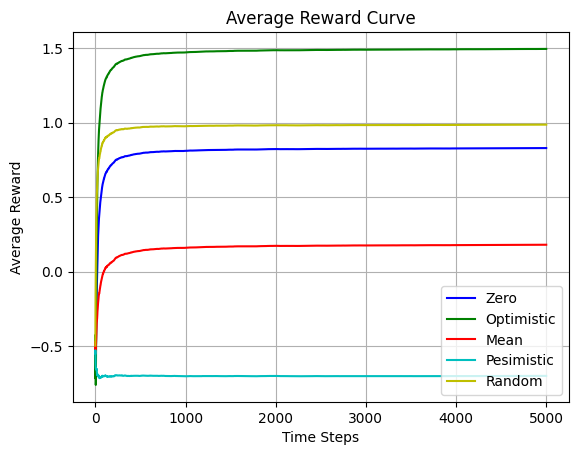

In [32]:
comp_plot(regret_greedy, min_regret_greedy, avg_regret_greedy, max_regret_greedy, rnd_regret_greedy, \
          mean_rewards_greedy, min_mean_rewards_greedy, avg_mean_rewards_greedy, max_mean_rewards_greedy, \
          rnd_mean_rewards_greedy)

## Section 6: The bandit algorithm with ε-Greedy action selection and true average update (Experiment III)

#### <div style="text-align: right"><span style="color:red">Maybe test out different ε values? :)</span></div>

### 6.1. Initializing with zero values:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.69304036 -0.47443235 -0.2954945  -1.77616029  0.21585127 -2.0010973
 -0.55576412  0.33640346  1.55009007 -1.37973313]

Euclidean distance from q_star vector: 0.04200598739457517
Total Reward: 6149.689412491696
Mean Reward: 1.229937882498339


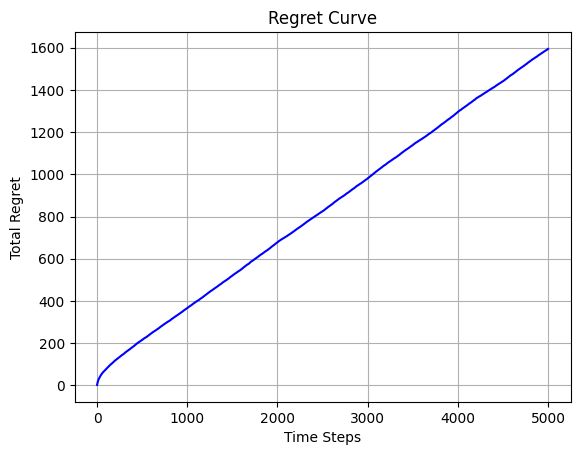

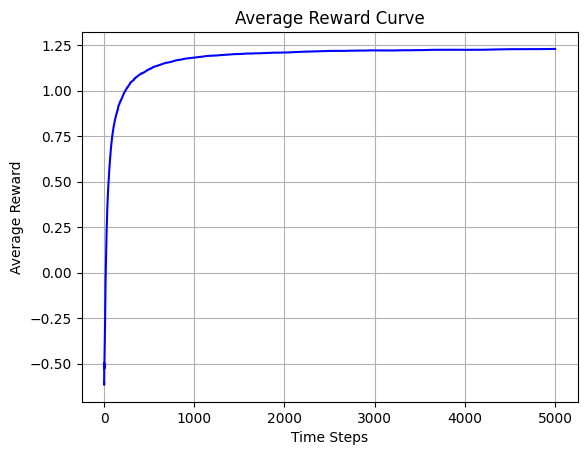

In [33]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : e_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.15
         }

#Run the experiment and plot:
estimates_e_greedy, total_reward_e_greedy, mean_rewards_e_greedy, regret_e_greedy = procedure(inputs,horizon)
plot_bandits(horizon, estimates_e_greedy, total_reward_e_greedy, mean_rewards_e_greedy, regret_e_greedy, q_star)

### 6.2. Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.69760826 -0.47463829 -0.29687732 -1.77602542  0.22390816 -1.99977078
 -0.55741445  0.33802989  1.55015648 -1.37983686]

Euclidean distance from q_star vector: 0.04302534538168682
Total Reward: 6119.687826031495
Mean Reward: 1.2239375652062994


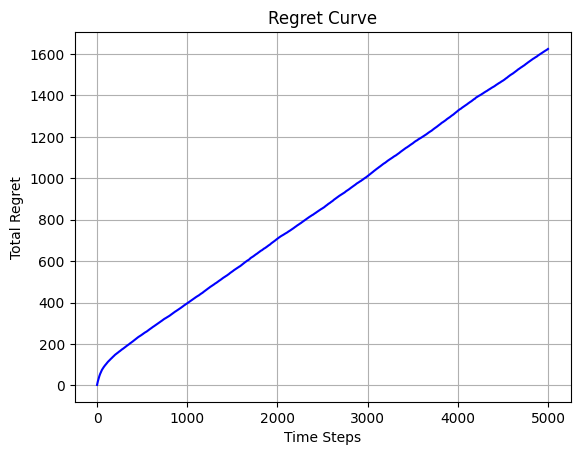

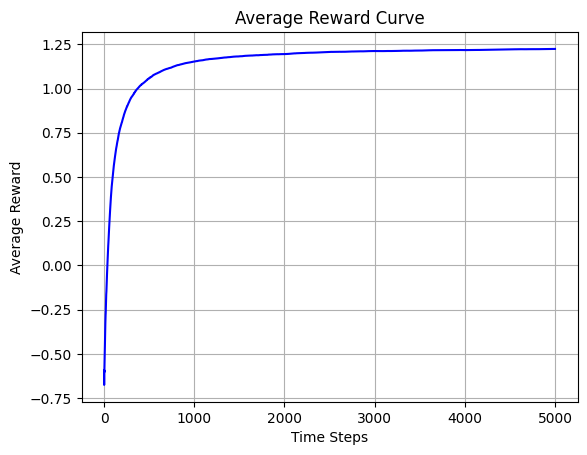

In [34]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : e_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.15
         }

#Run the experiment and plot:
min_estimates_e_greedy, min_total_reward_e_greedy, min_mean_rewards_e_greedy, min_regret_e_greedy = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_e_greedy, min_total_reward_e_greedy, min_mean_rewards_e_greedy, min_regret_e_greedy, q_star)

### 6.3. Initializing with Mean:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.69482885 -0.47673363 -0.29994631 -1.77598104  0.21863511 -1.99945965
 -0.55815917  0.33324621  1.55011077 -1.37967608]

Euclidean distance from q_star vector: 0.03936158162241867
Total Reward: 6127.1563777508945
Mean Reward: 1.2254312755501795


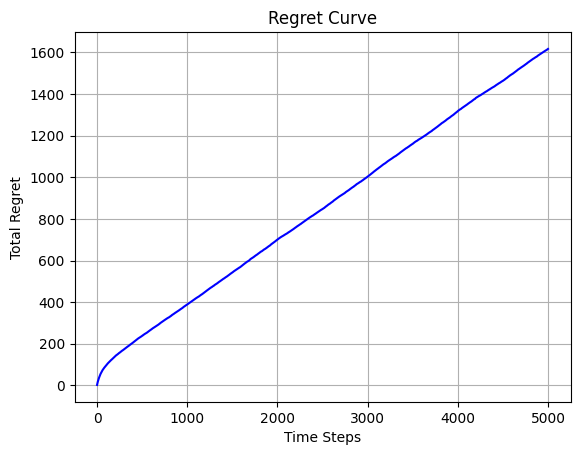

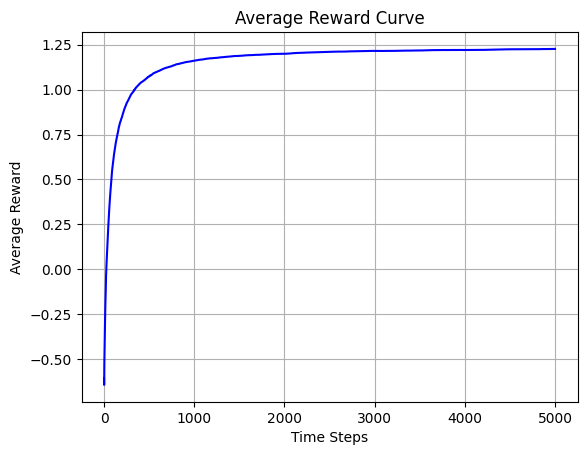

In [35]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : e_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.15
         }

#Run the experiment and plot:
avg_estimates_e_greedy, avg_total_reward_e_greedy, avg_mean_rewards_e_greedy, avg_regret_e_greedy = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_e_greedy, avg_total_reward_e_greedy, avg_mean_rewards_e_greedy, avg_regret_e_greedy, q_star)

### 6.4. Initializing with Optimistic:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.69191103 -0.47631296 -0.29281138 -1.77617422  0.22794477 -2.00262437
 -0.55615232  0.33403712  1.54997566 -1.37787915]

Euclidean distance from q_star vector: 0.046900180571839874
Total Reward: 6185.228779565598
Mean Reward: 1.237045755913119


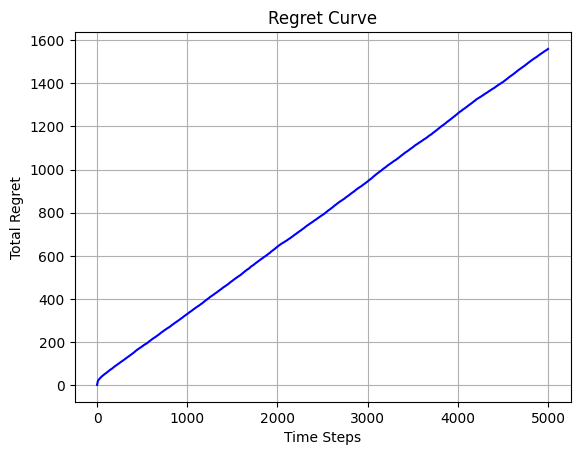

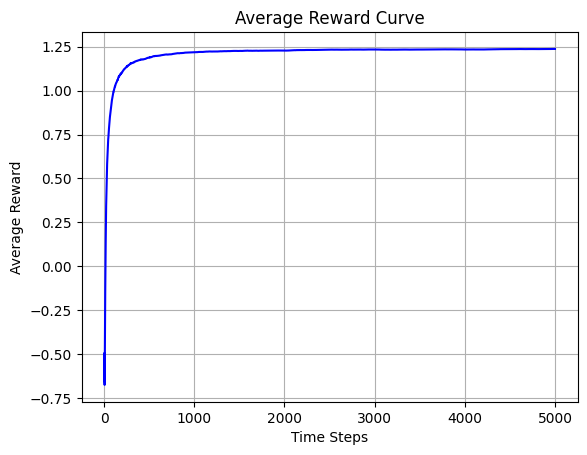

In [36]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : e_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.15
         }

#Run the experiment and plot:
max_estimates_e_greedy, max_total_reward_e_greedy, max_mean_rewards_e_greedy, max_regret_e_greedy = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_e_greedy, max_total_reward_e_greedy, max_mean_rewards_e_greedy, max_regret_e_greedy, q_star)

### 6.5. Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.69339748 -0.47170863 -0.29410383 -1.77694738  0.22213688 -2.00076162
 -0.55774947  0.33653729  1.55016308 -1.38034168]

Euclidean distance from q_star vector: 0.046166784562601544
Total Reward: 6161.581704255997
Mean Reward: 1.2323163408511995


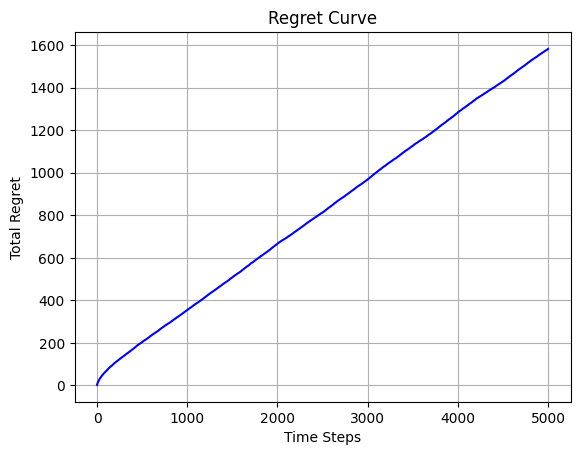

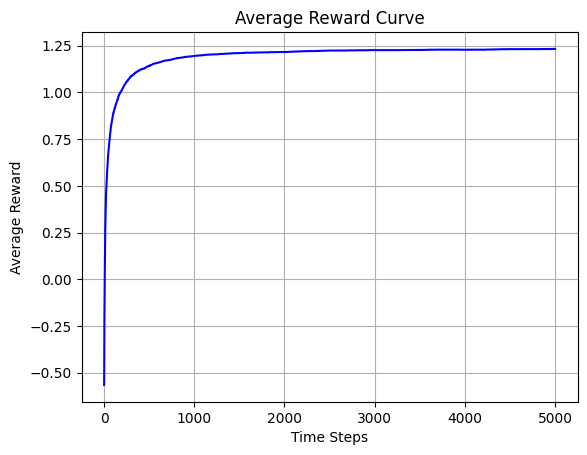

In [37]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : e_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.15
         }

#Run the experiment and plot:
rnd_estimates_e_greedy, rnd_total_reward_e_greedy, rnd_mean_rewards_e_greedy, rnd_regret_e_greedy = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_e_greedy, rnd_total_reward_e_greedy, rnd_mean_rewards_e_greedy, rnd_regret_e_greedy, q_star)

### 6.6. Compare all:

Let's see a comparison between the different initialization strategies for the e-greedy action selection strategy:

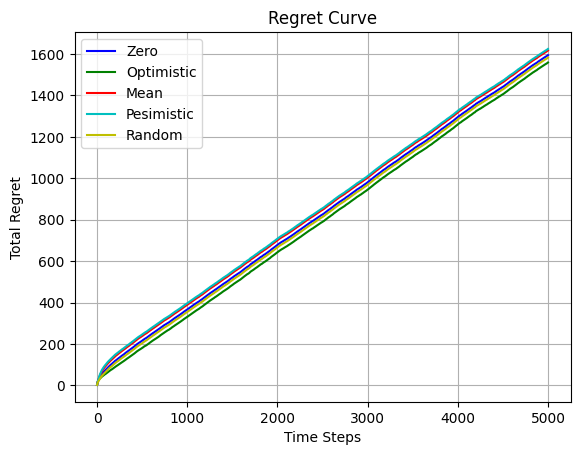

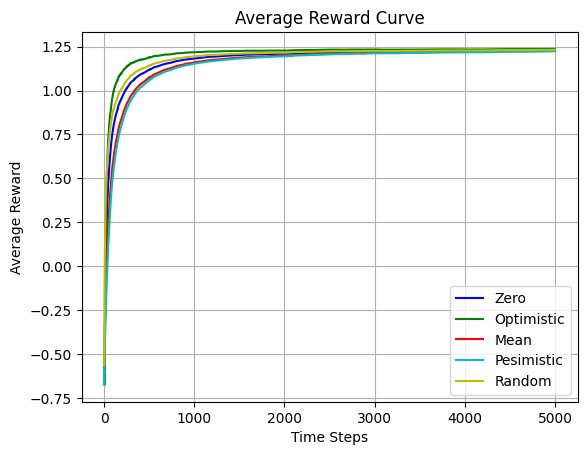

In [38]:
comp_plot(regret_e_greedy, min_regret_e_greedy, avg_regret_e_greedy, max_regret_e_greedy, rnd_regret_e_greedy, \
          mean_rewards_e_greedy, min_mean_rewards_e_greedy, avg_mean_rewards_e_greedy, max_mean_rewards_e_greedy, \
          rnd_mean_rewards_e_greedy)

## Section 7: The bandit algorithm with ε-Greedy with epsilon decay action selection and true average update (Experiment IV)

#### <div style="text-align: right"><span style="color:red">Maybe test out different ε and kappa values? (Especially the limit cases 0, 1):)</span></div>

### 7.1. Initializing with zero values:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.74583842 -0.49404065 -0.32290415 -1.7998631   0.18020096 -1.99435281
 -0.59026757  0.27079739  1.54938012 -1.32598038]

Euclidean distance from q_star vector: 0.11104722082894167
Total Reward: 7441.3077571671965
Mean Reward: 1.4882615514334403


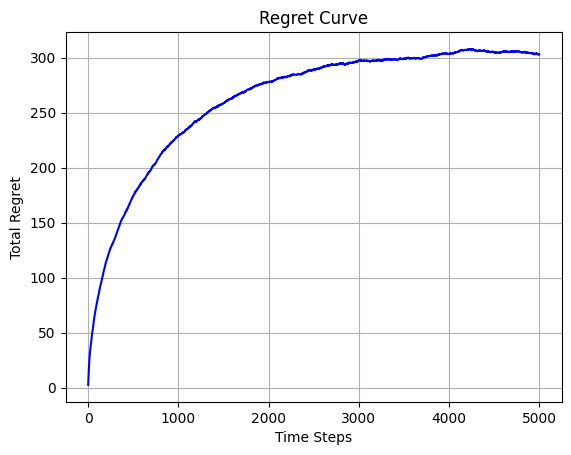

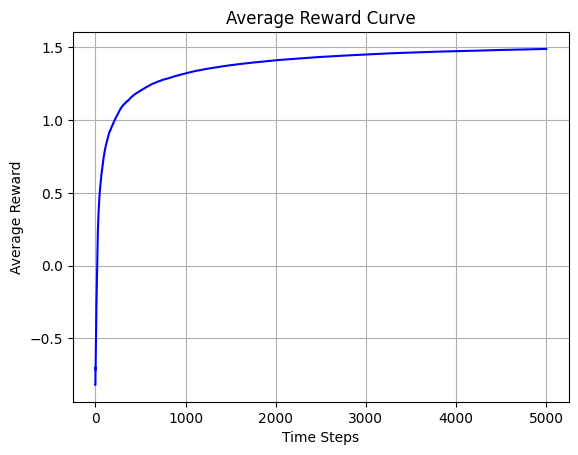

In [46]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.1,# The epsilon parameter. (try with 0.01 as well--will it get stuck to lockal minima?)
          "kappa"             : 0.001, # Decay coefficient
         }

#Run the experiment and plot:
estimates_e_decay_greedy, total_reward_e_decay_greedy, mean_rewards_e_decay_greedy, regret_e_decay_greedy = procedure(inputs,horizon)
plot_bandits(horizon, estimates_e_decay_greedy, total_reward_e_decay_greedy, mean_rewards_e_decay_greedy, regret_e_decay_greedy, q_star)

### 7.2. Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.7496652  -0.46424803 -0.30910654 -1.80024075  0.19914566 -2.01052934
 -0.58433561  0.28677893  1.54923077 -1.33323937]

Euclidean distance from q_star vector: 0.09889356395116662
Total Reward: 7348.922694146201
Mean Reward: 1.46978453882924


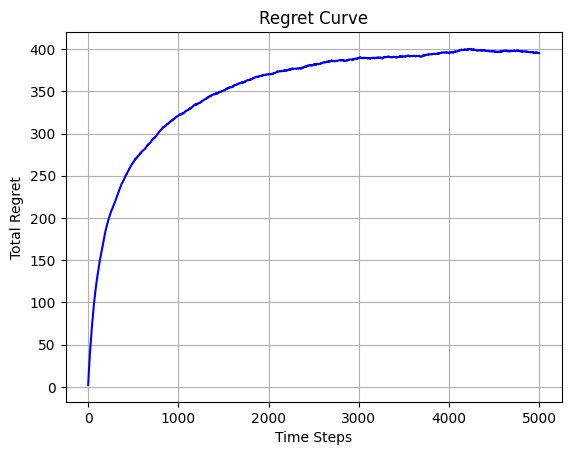

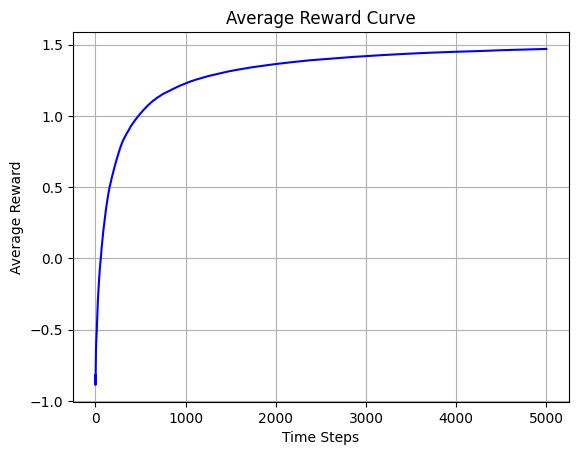

In [47]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.1,# The epsilon parameter. (try with 0.01 as well--will it get stuck to lockal minima?)
          "kappa"             : 0.001, # Decay coefficient
         }

#Run the experiment and plot:
min_estimates_e_decay_greedy, min_total_reward_e_decay_greedy, min_mean_rewards_e_decay_greedy, min_regret_e_decay_greedy = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_e_decay_greedy, min_total_reward_e_decay_greedy, min_mean_rewards_e_decay_greedy, min_regret_e_decay_greedy, q_star)

### 7.3. Initializing with Mean:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.75951059 -0.51819908 -0.34729734 -1.79716993  0.18973474 -2.00384877
 -0.59542616  0.27430464  1.54933238 -1.33024055]

Euclidean distance from q_star vector: 0.1173448888902378
Total Reward: 7382.794046260401
Mean Reward: 1.4765588092520803


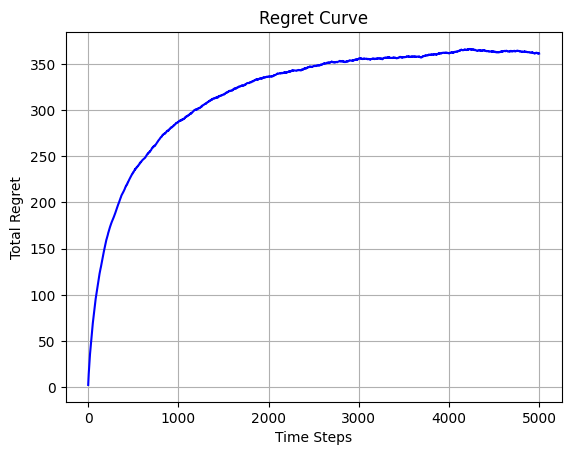

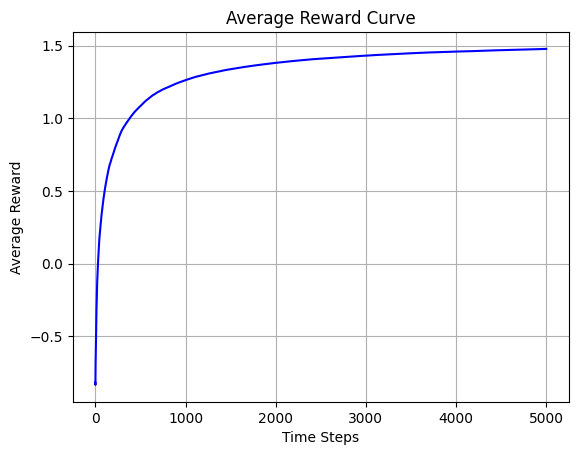

In [48]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.1,# The epsilon parameter. (try with 0.01 as well--will it get stuck to lockal minima?)
          "kappa"             : 0.001, # Decay coefficient
         }

#Run the experiment and plot:
avg_estimates_e_decay_greedy, avg_total_reward_e_decay_greedy, avg_mean_rewards_e_decay_greedy, avg_regret_e_decay_greedy = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_e_decay_greedy, avg_total_reward_e_decay_greedy, avg_mean_rewards_e_decay_greedy, avg_regret_e_decay_greedy, q_star)

### 7.4. Initializing with Optimistic:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.72915016 -0.48072571 -0.31111374 -1.78125752  0.23437894 -2.01563567
 -0.57387022  0.30992561  1.54900654 -1.34271141]

Euclidean distance from q_star vector: 0.06448950564546742
Total Reward: 7509.542188109697
Mean Reward: 1.5019084376219407


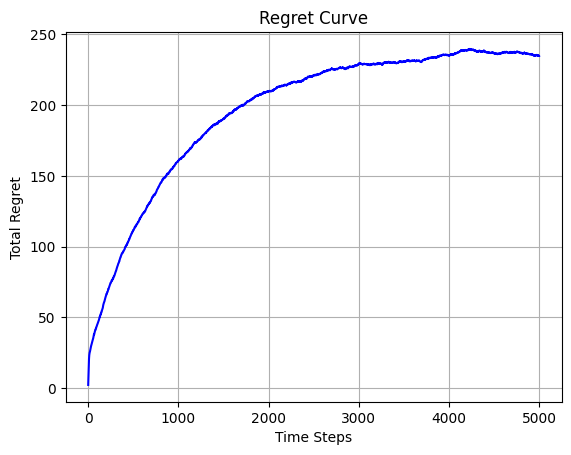

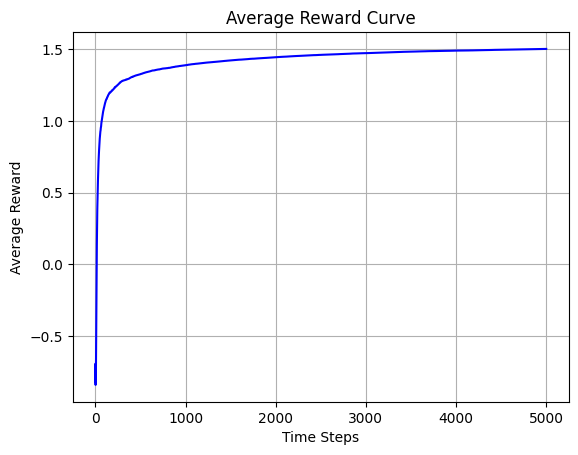

In [58]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.1,# The epsilon parameter. (try with 0.01 as well--will it get stuck to lockal minima?)
          "kappa"             : 0.001, # Decay coefficient
         }

#Run the experiment and plot:
max_estimates_e_decay_greedy, max_total_reward_e_decay_greedy, max_mean_rewards_e_decay_greedy, max_regret_e_decay_greedy = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_e_decay_greedy, max_total_reward_e_decay_greedy, max_mean_rewards_e_decay_greedy, max_regret_e_decay_greedy, q_star)

### 7.5. Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.72286023 -0.45819889 -0.31152349 -1.79573749  0.20177575 -2.01086467
 -0.60464462  0.29561855  1.54887254 -1.33457743]

Euclidean distance from q_star vector: 0.09210628239765598
Total Reward: 7453.7872894055035
Mean Reward: 1.4907574578811014


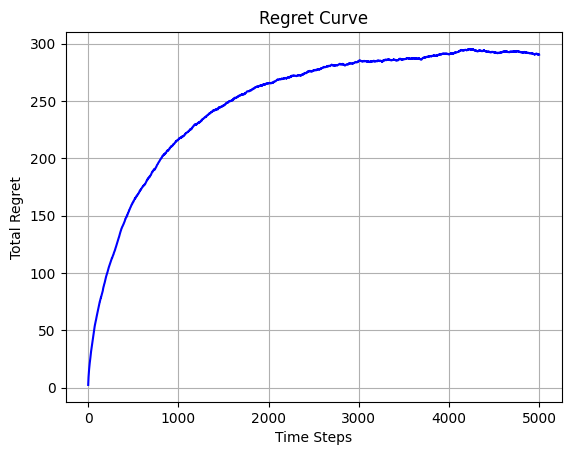

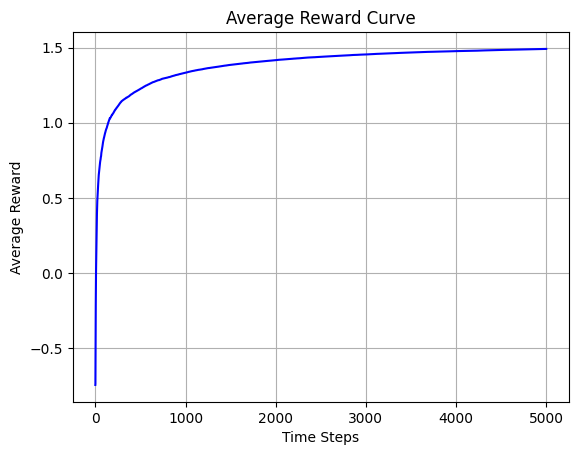

In [ ]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : e_decay_greedy_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "epsilon"           : 0.1,# The epsilon parameter. (try with 0.01 as well--will it get stuck to lockal minima?)
          "kappa"             : 0.001, # Decay coefficient
         }

#Run the experiment and plot:
rnd_estimates_e_decay_greedy, rnd_total_reward_e_decay_greedy, rnd_mean_rewards_e_decay_greedy, rnd_regret_e_decay_greedy = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_e_decay_greedy, rnd_total_reward_e_decay_greedy, rnd_mean_rewards_e_decay_greedy, rnd_regret_e_decay_greedy, q_star)

### 7.6. Compare all:

Let's see a comparison between the different initialization strategies for the e-Greedy with epsilon decay action selection strategy:

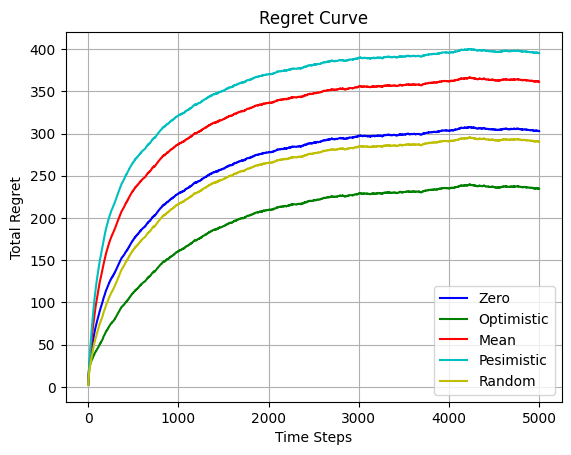

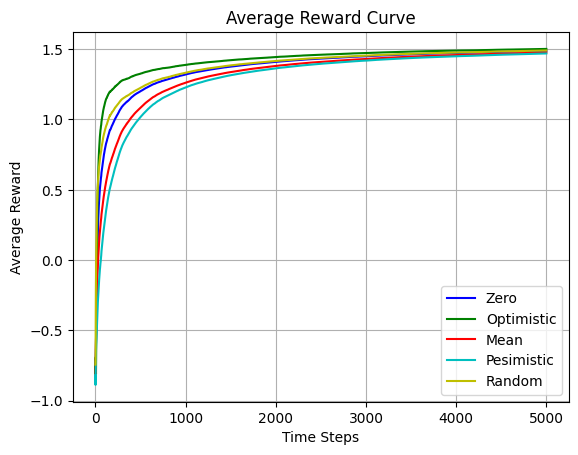

In [59]:
comp_plot(regret_e_decay_greedy, min_regret_e_decay_greedy, avg_regret_e_decay_greedy,\
          max_regret_e_decay_greedy, rnd_regret_e_decay_greedy, mean_rewards_e_decay_greedy,\
          min_mean_rewards_e_decay_greedy, avg_mean_rewards_e_decay_greedy,\
          max_mean_rewards_e_decay_greedy, rnd_mean_rewards_e_decay_greedy)

## Section 8: The bandit algorithm with Upper Confidence Bound action selection and true average update (Experiment V)

#### <div style="text-align: right"><span style="color:red">Maybe test out different c values? :)</span></div>

### 8.1. Initializing with zero values:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.82649456 -0.63700592 -0.44040821 -2.07782492  0.10603959 -2.25051244
 -0.69608563  0.25559854  1.54904393 -1.69347535]

Euclidean distance from q_star vector: 0.5936531708164323
Total Reward: 7616.255697235606
Mean Reward: 1.5232511394471209


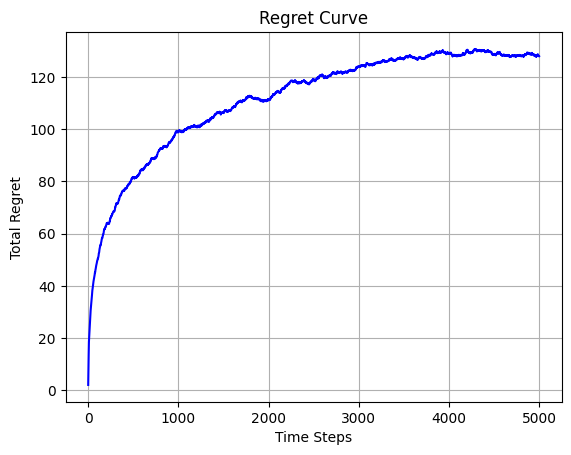

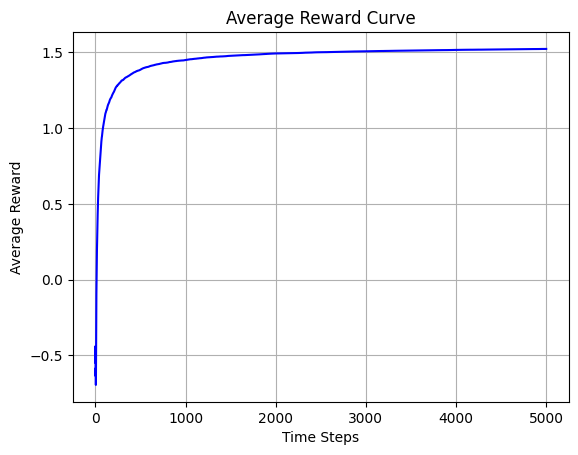

In [60]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : ucb_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "c"                 : 2. # The c parameter
         }

#Run the experiment and plot:
estimates_ucb, total_reward_ucb, mean_rewards_ucb, regret_ucb = procedure(inputs,horizon)
plot_bandits(horizon, estimates_ucb, total_reward_ucb, mean_rewards_ucb, regret_ucb, q_star)

### 8.2. Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.81932976 -0.63241705 -0.45144363 -2.10084322  0.0684112  -2.29953692
 -0.78299735  0.26655509  1.54933475 -1.83594766]

Euclidean distance from q_star vector: 0.7379968570624327
Total Reward: 7619.082802697305
Mean Reward: 1.5238165605394605


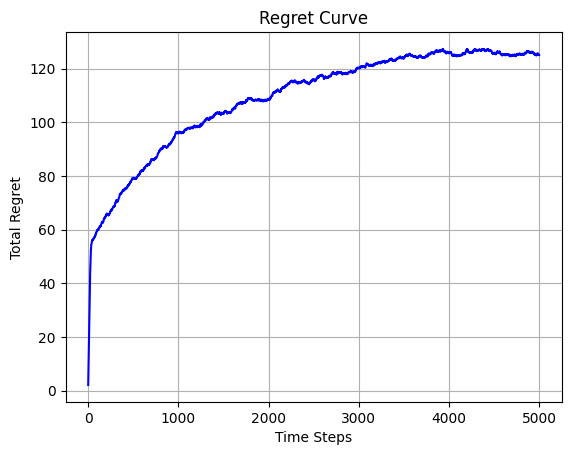

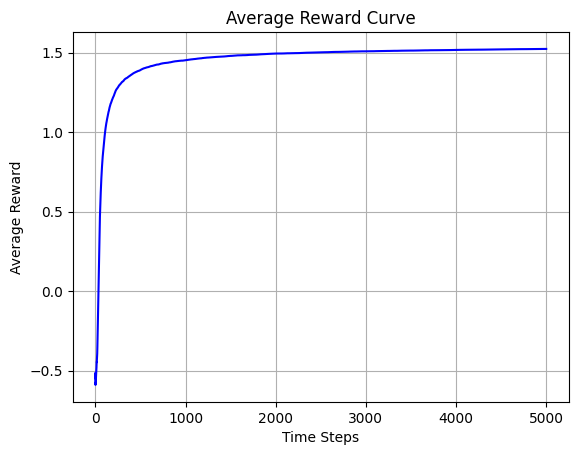

In [61]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : ucb_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "c"                 : 2. # The c parameter
         }

#Run the experiment and plot:
min_estimates_ucb, min_total_reward_ucb, min_mean_rewards_ucb, min_regret_ucb = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_ucb, min_total_reward_ucb, min_mean_rewards_ucb, min_regret_ucb, q_star)

### 8.3. Initializing with Mean:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.80239205 -0.63610015 -0.54451927 -1.94456256  0.09539497 -2.20198005
 -0.82342986  0.25757015  1.54931722 -1.70836571]

Euclidean distance from q_star vector: 0.5971163696874282
Total Reward: 7618.499094132205
Mean Reward: 1.5236998188264415


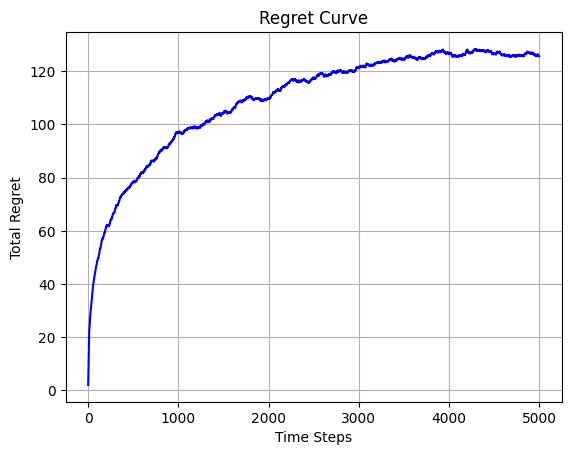

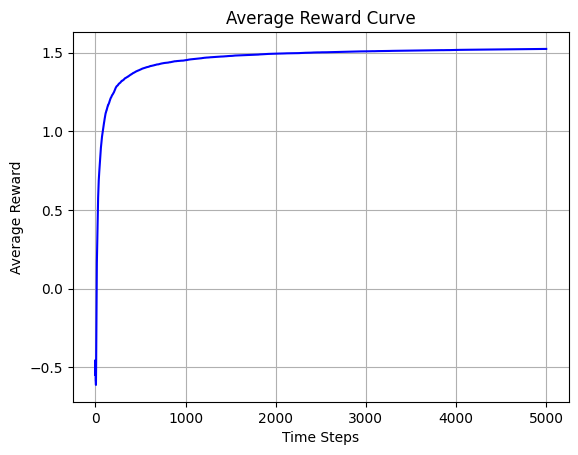

In [62]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : ucb_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "c"                 : 2. # The c parameter
         }

#Run the experiment and plot:
avg_estimates_ucb, avg_total_reward_ucb, avg_mean_rewards_ucb, avg_regret_ucb = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_ucb, avg_total_reward_ucb, avg_mean_rewards_ucb, avg_regret_ucb, q_star)

### 8.4. Initializing with Optimistic:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.84275839 -0.57011282 -0.47155183 -2.04719464  0.06496001 -2.26452907
 -0.83172473  0.25706953  1.54926661 -1.67924385]

Euclidean distance from q_star vector: 0.6283037602430972
Total Reward: 7617.7432966725055
Mean Reward: 1.5235486593345018


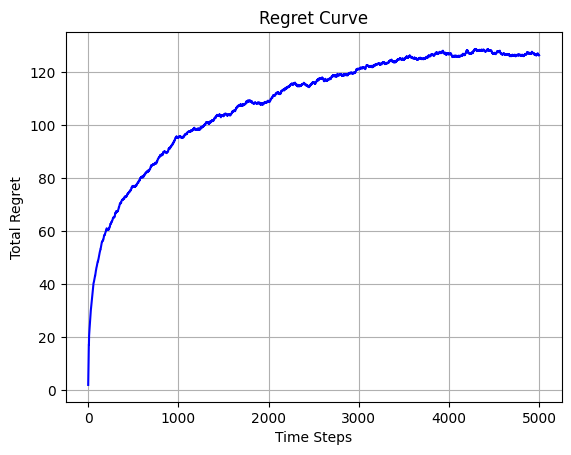

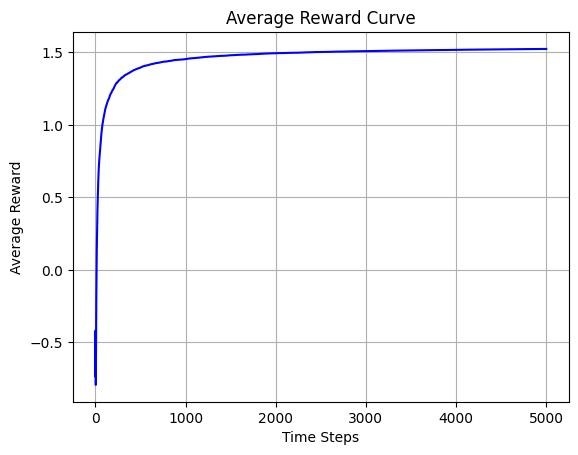

In [63]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : ucb_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "c"                 : 2. # The c parameter
         }

#Run the experiment and plot:
max_estimates_ucb, max_total_reward_ucb, max_mean_rewards_ucb, max_regret_ucb = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_ucb, max_total_reward_ucb, max_mean_rewards_ucb, max_regret_ucb, q_star)

### 8.5. Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-0.84040939 -0.72088889 -0.39419938 -2.00061678  0.11267399 -2.31712727
 -0.71472947  0.22004779  1.54921024 -1.58662994]

Euclidean distance from q_star vector: 0.5701423373653007
Total Reward: 7617.014704865406
Mean Reward: 1.5234029409730818


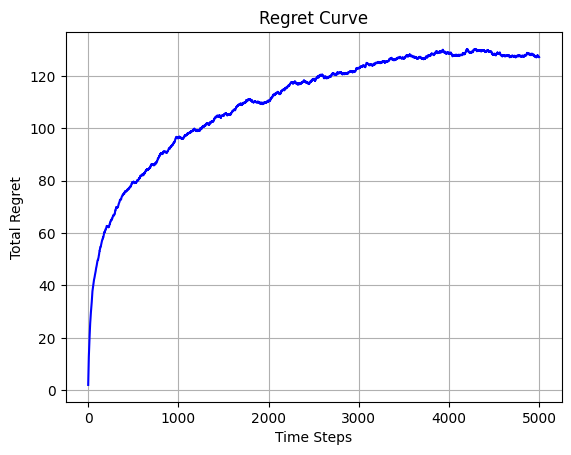

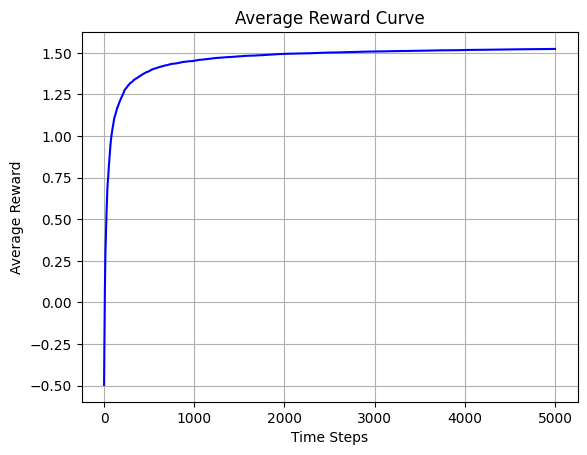

In [66]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : ucb_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "c"                 : 2. # The c parameter
         }

#Run the experiment and plot:
rnd_estimates_ucb, rnd_total_reward_ucb, rnd_mean_rewards_ucb, rnd_regret_ucb = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_ucb, rnd_total_reward_ucb, rnd_mean_rewards_ucb, rnd_regret_ucb, q_star)

### 8.6. Compare all:

Let's see a comparison between the different initialization strategies for the ucb action selection strategy:

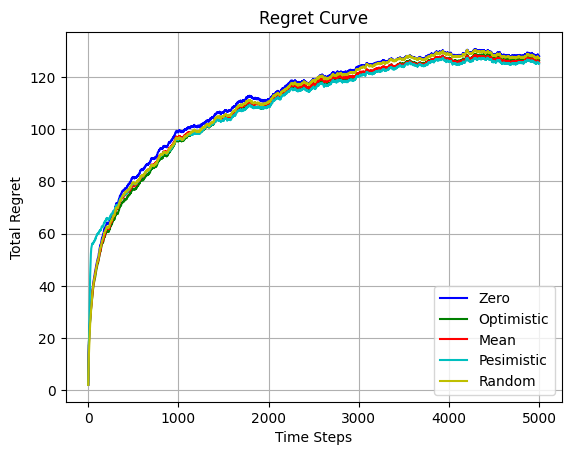

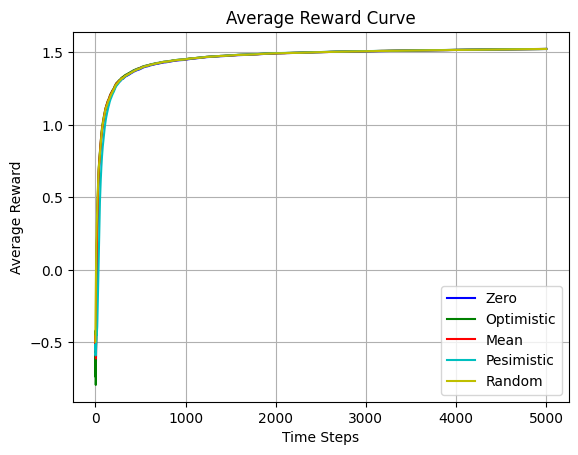

In [67]:
comp_plot(regret_ucb, min_regret_ucb, avg_regret_ucb, max_regret_ucb, rnd_regret_ucb, \
          mean_rewards_ucb, min_mean_rewards_ucb, avg_mean_rewards_ucb, max_mean_rewards_ucb, \
          rnd_mean_rewards_ucb)

## Section 9: The bandit algorithm with Softmax action selection and true average update (Experiment VI)

#### <div style="text-align: right"><span style="color:red">Maybe test out different τ values? What happens very close to 0 and with very high τ values? :)</span></div>

### 9.1. Initializing with zero values:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.02560411 -0.74968172 -0.82255957 -1.92188255 -0.10883275 -2.19051303
 -0.90257327  0.02080786  1.54889726 -1.68770468]

Euclidean distance from q_star vector: 0.9493732951504908
Total Reward: 7526.084206433505
Mean Reward: 1.5052168412867004


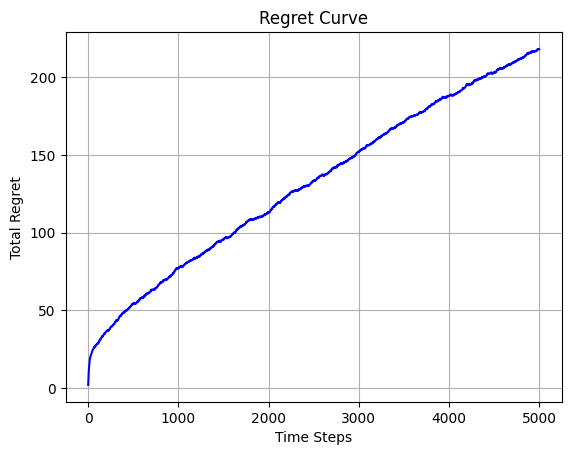

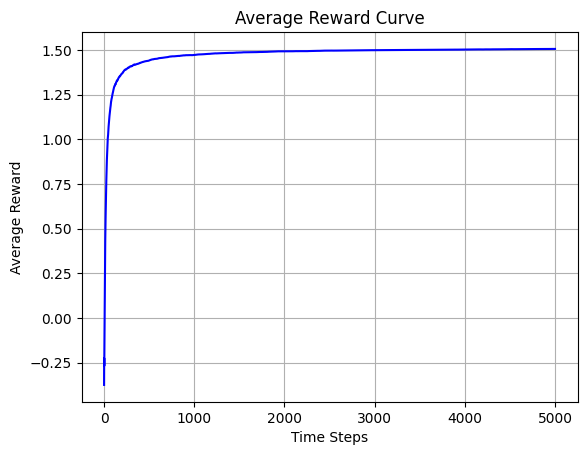

In [68]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : softmax_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "tau"               : 0.3 # The tau parameter
         }

#Run the experiment and plot:
estimates_sm, total_reward_sm, mean_rewards_sm, regret_sm = procedure(inputs,horizon)
plot_bandits(horizon, estimates_sm, total_reward_sm, mean_rewards_sm, regret_sm, q_star)

### 9.2. Initializing with Pessimistic:
What do you think the expected reward is? 

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.48080821 -1.37038519 -1.37596297 -2.03850202 -1.05711527 -2.16062732
 -1.3773152  -0.66465843  0.98034263 -1.8071025 ]

Euclidean distance from q_star vector: 2.5258942848237935
Total Reward: 5662.094558667307
Mean Reward: 1.132418911733461


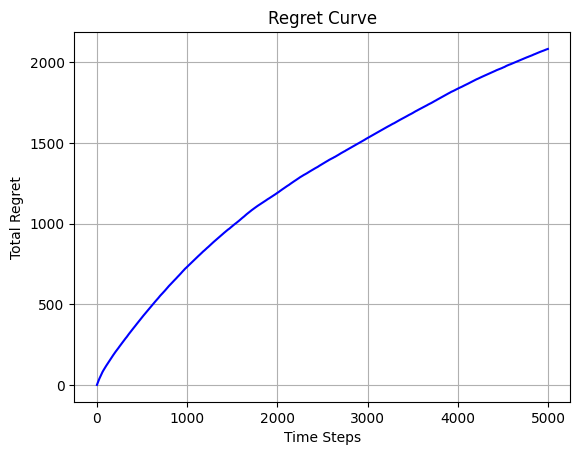

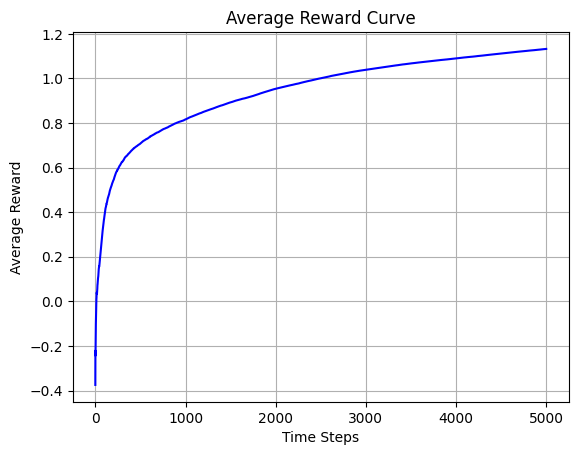

In [69]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : softmax_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "tau"               : 0.3 # The tau parameter
         }

#Run the experiment and plot:
min_estimates_sm, min_total_reward_sm, min_mean_rewards_sm, min_regret_sm = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_sm, min_total_reward_sm, min_mean_rewards_sm, min_regret_sm, q_star)

### 9.3. Initializing with Mean:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.08768611 -0.85811154 -0.68359176 -2.0309034  -0.15937231 -2.07372698
 -0.91522352  0.13284577  1.54903871 -1.66911342]

Euclidean distance from q_star vector: 0.9417670646677611
Total Reward: 7518.238319950503
Mean Reward: 1.5036476639901013


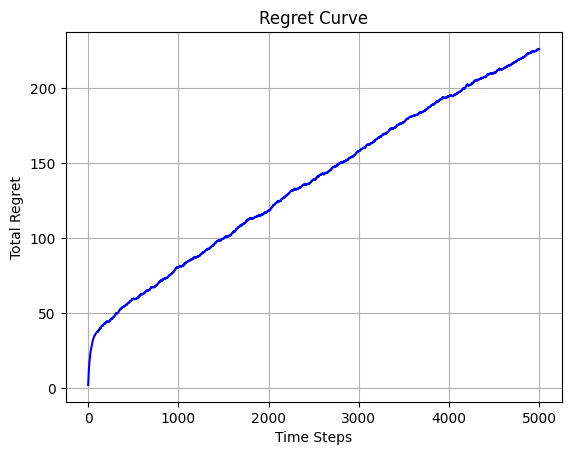

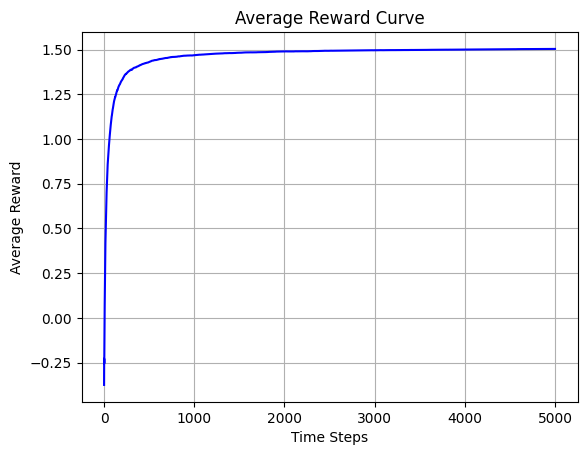

In [70]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : softmax_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "tau"               : 0.3 # The tau parameter
         }

#Run the experiment and plot:
avg_estimates_sm, avg_total_reward_sm, avg_mean_rewards_sm, avg_regret_sm = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_sm, avg_total_reward_sm, avg_mean_rewards_sm, avg_regret_sm, q_star)

### 9.4. Initializing with Optimistic:
What do you think the expected reward is?

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.05934678 -0.838852   -0.67920748 -2.0466822  -0.08636255 -2.24947568
 -0.9120786   0.09745825  1.54906079 -1.64533091]

Euclidean distance from q_star vector: 0.928714911741562
Total Reward: 7527.3220424841065
Mean Reward: 1.5054644084968212


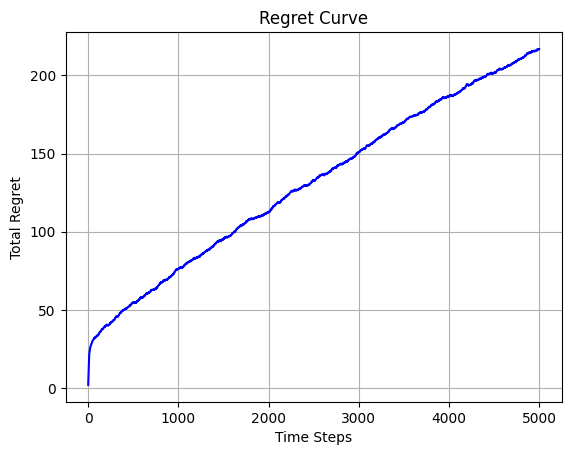

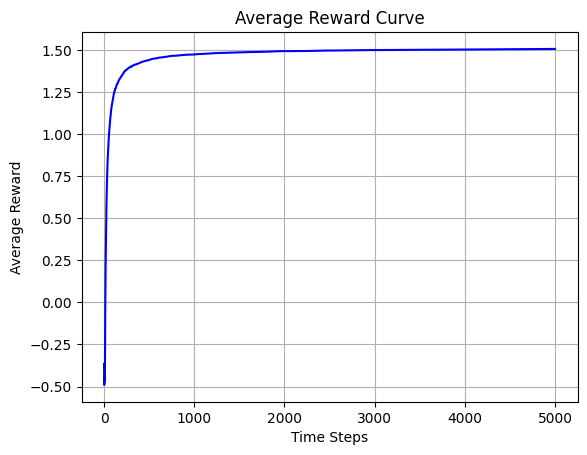

In [71]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : softmax_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "tau"               : 0.3 # The tau parameter
         }

#Run the experiment and plot:
max_estimates_sm, max_total_reward_sm, max_mean_rewards_sm, max_regret_sm = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_sm, max_total_reward_sm, max_mean_rewards_sm, max_regret_sm, q_star)

### 9.5. Initializing with Random
What do you think the expected reward is?
(we will use the average of 100 random initializations, so that the results are significant):

True q values:[-0.70318731, -0.49028236, -0.32181433, -1.75507872, 0.20666447, -2.01126457, -0.55725071, 0.33721701, 1.54883597, -1.37073656]
Learned Estimates: [-1.16240759 -0.9347302  -0.73406236 -1.89390802 -0.14385152 -2.00483825
 -1.03619997  0.03676269  1.43525417 -1.56776924]

Euclidean distance from q_star vector: 1.044954449767622
Total Reward: 7225.083156674106
Mean Reward: 1.445016631334822


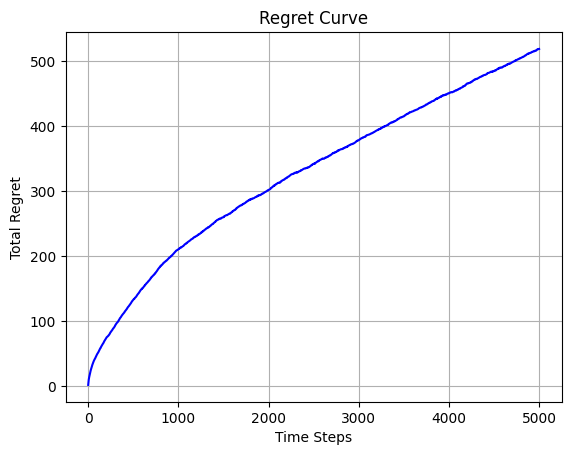

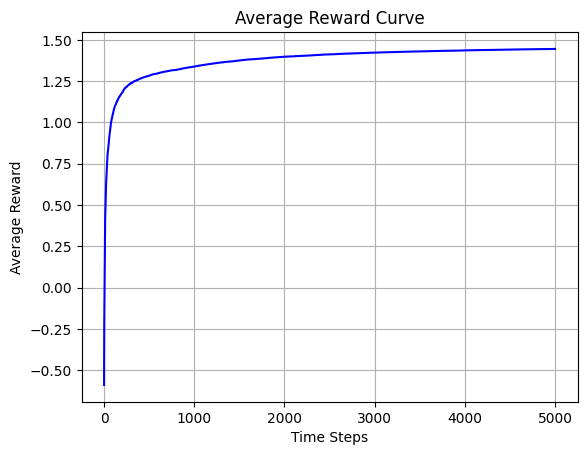

In [72]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : softmax_action_selection, # Action selection strategy
          "update_rule"       : update_rule, # The update rule
          "tau"               : 0.3 # The tau parameter
         }

#Run the experiment and plot:
rnd_estimates_sm, rnd_total_reward_sm, rnd_mean_rewards_sm, rnd_regret_sm = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_sm, rnd_total_reward_sm, rnd_mean_rewards_sm, rnd_regret_sm, q_star)

### 9.6. Compare all:

Let's see a comparison between the different initialization strategies for the softmax action selection strategy:

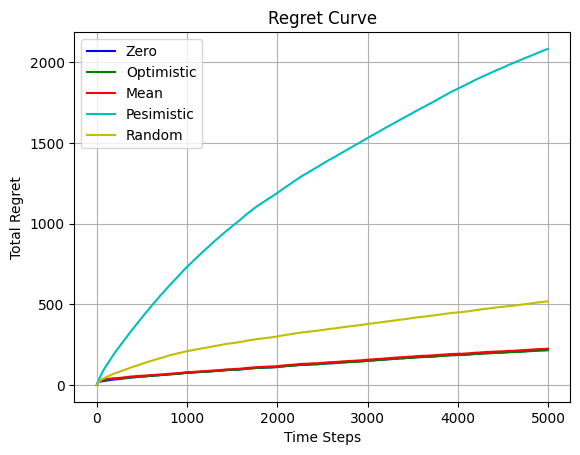

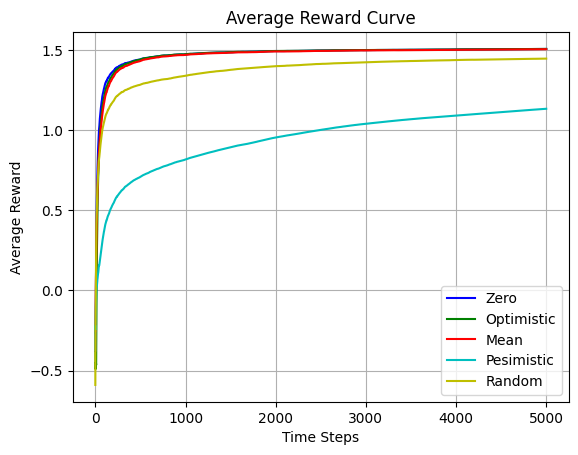

In [73]:
comp_plot(regret_sm, min_regret_sm, avg_regret_sm, max_regret_sm, rnd_regret_sm, \
          mean_rewards_sm, min_mean_rewards_sm, avg_mean_rewards_sm, max_mean_rewards_sm, \
          rnd_mean_rewards_sm)

## Section 10: Comparing Bandit Algorithms
Compare the bandit algorithms through plotting.

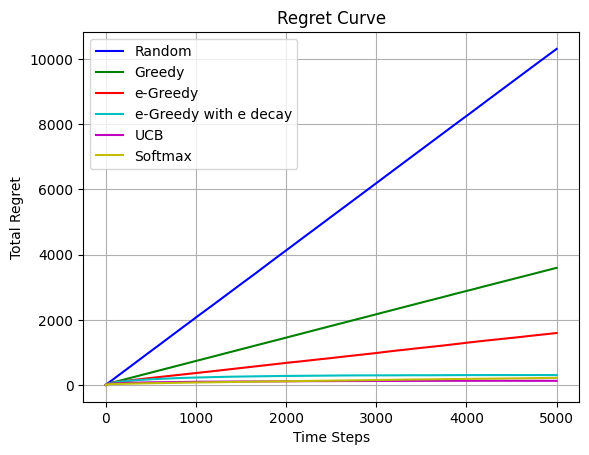

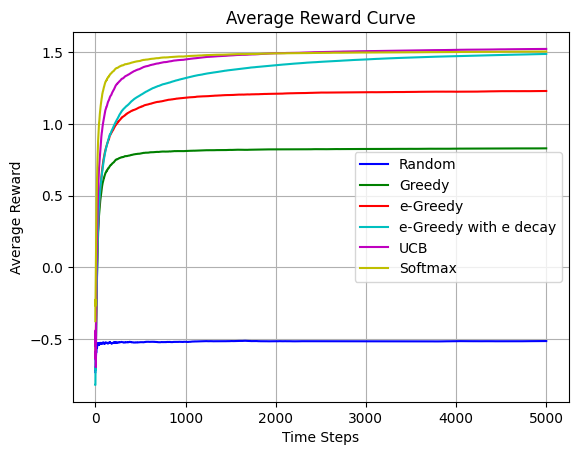

In [74]:
### Plot the results of all the algorithms ###
##############################################

fig, ax = plt.subplots()
ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret_rand), 'b-')
ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret_greedy), 'g-')
ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret_e_greedy), 'r-')
ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret_e_decay_greedy), 'c-')
ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret_ucb), 'm-')
ax.plot(np.linspace(0,horizon-1,horizon), np.cumsum(regret_sm), 'y-')
ax.grid()
ax.set(xlabel='Time Steps', ylabel='Total Regret',
       title='Regret Curve')
plt.legend(['Random','Greedy','e-Greedy','e-Greedy with e decay','UCB','Softmax'])
plt.show()

fig, ax = plt.subplots()
ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards_rand, 'b-')
ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards_greedy, 'g-')
ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards_e_greedy, 'r-')
ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards_e_decay_greedy, 'c-')
ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards_ucb, 'm-')
ax.plot(np.linspace(0,horizon-1,horizon), mean_rewards_sm, 'y-')
ax.grid()
ax.set(xlabel='Time Steps', ylabel='Average Reward',
       title='Average Reward Curve')
plt.legend(['Random','Greedy','e-Greedy','e-Greedy with e decay','UCB','Softmax'])
plt.show()

## Section 11: Exercises

### 11.1. Exercise 1: Implement the gradient bandits action selection and update rule methods yourself:

In [24]:
def gradient_bandits_action_selection(estimates, inputs, t, action_select_counter):
    # Parameters (k and tau)
    k = inputs["k"]
    tau = inputs["tau"]

    # Compute the probabilities for each action (softmax) based on the estimates
    action_probs = np.exp(estimates/tau)/np.sum(np.exp(estimates/tau))

    # Select an action based on the probabilities
    action = rng3.choice(k, p=action_probs)
    return action

def gradient_bandits_update_rule(estimates, action, reward, inputs, action_select_counter, mean_reward):
    # Parameters (k, tau, and alpha)
    k = inputs["k"]
    tau = inputs["tau"]
    alpha = inputs["alpha"]

    # Compute the probabilities for each action (softmax) based on the estimates
    action_probs = np.exp(estimates/tau)/np.sum(np.exp(estimates/tau))

    # Updating the estimate for the current action (A_t)
    estimates[action] = estimates[action] + alpha*(reward - mean_reward)*(1-action_probs[action])

    # Updating the estimate for the other actions
    estimates = [estimates[i] if i == action else estimates[i] - alpha*(reward - mean_reward)*action_probs[i] for i in range(k)]
    return estimates

#### Run the gradient bandits with zeros initialization:

In [25]:
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : ZeroInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
estimates_gradient, total_reward_gradient, mean_rewards_gradient, regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, estimates_gradient, total_reward_gradient, mean_rewards_gradient, regret_gradient, q_star)

TypeError: unsupported operand type(s) for /: 'list' and 'float'

#### Will gradient bandits have a different result using other initializations?
Run the gradient bandits using different initializations to find out if you were correct:

In [ ]:
# Pessimistic Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MinInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
min_estimates_gradient, min_total_reward_gradient, min_mean_rewards_gradient, min_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, min_estimates_gradient, min_total_reward_gradient, min_mean_rewards_gradient, min_regret_gradient, q_star)

In [ ]:
# Average Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MeanInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
avg_estimates_gradient, avg_total_reward_gradient, avg_mean_rewards_gradient, avg_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, avg_estimates_gradient, avg_total_reward_gradient, avg_mean_rewards_gradient, avg_regret_gradient, q_star)

In [ ]:
# Optimistic Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : MaxInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
max_estimates_gradient, max_total_reward_gradient, max_mean_rewards_gradient, max_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, max_estimates_gradient, max_total_reward_gradient, max_mean_rewards_gradient, max_regret_gradient, q_star)

In [ ]:
# Random Initialization
#Seed our random engines:
rng2 = np.random.RandomState(1337)
rng3 = np.random.RandomState(1337)

#Initialize the experiment:
inputs = {"k"                 : k, # Number of actions
          "horizon"           : horizon, # Number of iterations
          "q_star"            : q_star, # The true unknown rewards
          "tau"               : 0.3, # The tau parameter
          "alpha"             : 0.1, # The learning rate
          "initialization"    : RandomInitialization, # Initialization strategy
          "action_selection"  : gradient_bandits_action_selection, # Action selection strategy
          "update_rule"       : gradient_bandits_update_rule # The update rule
         }

#Run the experiment and plot:
rnd_estimates_gradient, rnd_total_reward_gradient, rnd_mean_rewards_gradient, rnd_regret_gradient = procedure(inputs,horizon)
plot_bandits(horizon, rnd_estimates_gradient, rnd_total_reward_gradient, rnd_mean_rewards_gradient, rnd_regret_gradient, q_star)

In [ ]:
# Compare all
comp_plot(regret_gradient, min_regret_gradient, avg_regret_gradient, max_regret_gradient, rnd_regret_gradient, \
          mean_rewards_gradient, min_mean_rewards_gradient, avg_mean_rewards_gradient, max_mean_rewards_gradient, \
          rnd_mean_rewards_gradient)

### 11.2. Exercise 2: Implement a bandit of your own liking!
(A hybrid bandit maybe? Play with constant step size? Compare different greedy ones? Different gradient-based ones?)
